### Hands on Machine Learning chapter 07 실습

Ensemble learning and random forest


In [13]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 투표기반 분류기

In [3]:
heads_proba = 0.51
# 10,000번 던지기는 10번 실행
# 결과 행렬 (10000, 10)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
# 0 1 0 .... 1 
# .....
# .....
# 5100 5099 ...
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

그림 저장: law_of_large_numbers_plot


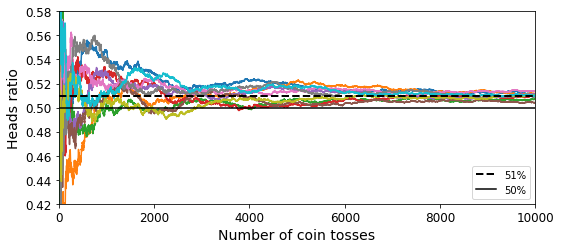

In [4]:
plt.figure(figsize=(8,3.5))
# plt.plot(cumulative_heads_ratio[:,0]) #하나만 보려면
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

# 횟수가 많아질수록 결국 51% 확률값으로 수렴된다

In [14]:
from scipy.stats import binom

print(1-binom.cdf(499, 1000, 0.51)) #cdf: 누적 확률 분포 (1000번중 750번은 앞면이 51%수준의 확률로 나올것이다)

0.7467502275561786


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard') 

# voting='hard': 다수결 투표, 직접 투표 방식
# 각각의 분류기의 결과를 같은 비중으로 본다. 위와같이 3개의 분류기의 결과중
# 가장 많이 나온 결과를 최종 결과로 채택한다.

In [7]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [17]:
from sklearn.metrics import accuracy_score

# 각각의 정확도 확인
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # clf.score(...) 이렇게도 가능
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    # 각각 accuracy는 86~89% --> ensemble로는 91.2%로 상향됨.

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [9]:
# 위와 같이 다시 fit()할 필요 없이(이미 훈련을 마친상황이기때문에)
# 다음과 같이 바로 호출할 수도 있다.
for clf in voting_clf.estimators_+[voting_clf]:
  print(clf.__class__.__name__, clf.score(X_test, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### 간접 투표

In [10]:
# 간접투표: 개별 분류기의 예측을 평균내어 확률이 가장 높은 클래스를 예측한다.
# 확률이 높은 투표에 더 많은 비중을 둔다. 직접 투표방식보다 성능이 더 좋다.
# 각 분류기가 클래스 예측 확률을 계산할수있어야함 (predict_proba()함수 사용가능한 분류기)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) 
#SVC는 확률을 반환하지않기때문에, Probability=True 설정 필요

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

# 개별보다 86~89% --> ensemble로 92% 수준 향상 가능

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 배깅 & 페이스팅 (bagging & pasting)

위와같이 다른 훈련 알고리즘을 함께 사용하지않고, 

하나의 훈련 알고리즘을 사용하면서 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킬수있다.

중복을 허용하여 샘플링하는 방식: bagging

중복을 허용하지 않고 샘플링하는 방식: pasting

### 배깅 앙상블 (bagging ensemble)

(pasting과는 다르게) bagging은 한 예측기를 위해 같은 훈련 샘플을 여러번 샘플링할 수 있다.

각각의 예측기가 훈련을 마치면, ensemble은 예측값들을 모아서 새로운 샘플에 대한 예측을 만든다. 

수집함수 -

  - 분류: statistical mode(통계적 최빈값) 사용

  - 회귀: statisical mean(평균값) 사용 

위와 같은 기준으로 수집함수를 통과하면 분산과 편향이 모두 감소하는 효과 있음.

그리고 CPU core나 서버에서 각 분류기들을 병렬로 동시에 학습시킬수 있다.

In [18]:
# bootstrapping aggregation
# 중복을 허용하는 sample선택 방법 (샘플을 선택하고, 다시 세트에 넣어서 다시 선택. 중복선택될 수 있다)
# 데이터셋에 좀 더 무작위성을 더해주는것


# sklearn기반 bagging구현방법
from sklearn.ensemble import BaggingClassifier # sklearn에서 제공하는 bagging&pasting용 API
from sklearn.tree import DecisionTreeClassifier #sub모델은 decisiont tree

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, #기반 모델은 decision tree 지정, 몇개 만들지 n_estimator로 지정
    max_samples=100, bootstrap=True, random_state=42) 
# default가 bootstrap=True : bagging방식 사용시 (pasting방식 사용시, False로 설정)
# max_samples=1.0 (1.0인경우 중복을 가만해서 훈련세트의 샘플이 모두들어가지 않을수도있다)
# n_jobs: sklearn이 훈련/예측에 사용할 CPU 코어 수를 지정 (-1: 모든 코어 사용을 의미함)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier은 기반이 되는 분류기가 deicisiontree classifier처럼 클래스 확률을 추정할 수 있으면, 자동으로 간접투표방식을 사용한다.


In [19]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [20]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [21]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    # 2차원 평면의 포인트
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


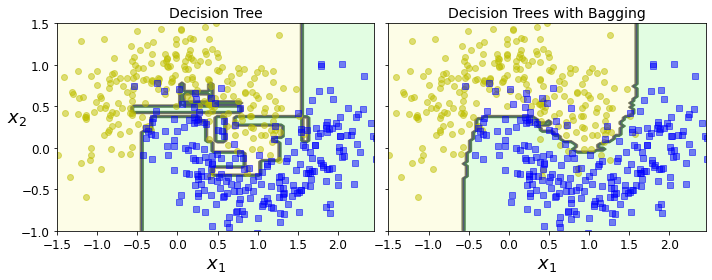

In [22]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()
# decision tree 하나인경우(left) 일반화가 부족한 더 복잡한 경계
# ensemble된경우 더 일반화된 모델 확보가능
# 오차개수는 비슷하지만, 결정경계가 ensemble이 덜 불규칙하다.

bootstrapping은 각 예측기가 학습하는 subset에 다양성을 증가시켜서, bagging이 pasting보다 편향이 조금 더 높다.

BUT

이런 경향은 예측기들의 상관관계를 줄여서 ensemble의 분산을 감소시킨다.

그래서 전반적으로 bagging이 더 나은 모델을 만든다. (일반적으로 더 선호)

BUT

시간과 CPU power여유가있다면 교차검증으로 bagging과 pasting 모두 평가해서 더 좋은것을 선택하는것이 가장 BEST

### OOB 평가 (out of bag)
 
bagging classifier는 기본값으로 중복을 허용한다.(bootstrap = True)

훈련세트 크기만큼인 m개의 샘플을 선택하는데, 평균적으로 훈련세트의 63%정도만 샘플링된다.

37% 수준의 sample이 훈련에 참여되지 않는것이다. 이것들을 oob(out of bag) samples라고 함.
(각각의 예측기마다 사용되지 못한 37%가 다름.)

이렇게 훈련세트에 사용되지 않은 샘플들을 사용해서 모델을 평가 할 수 있다. (따로 검증 세트/ 테스트 세트를 만들지 않고도)

ensemble 평가는 각 예측기의 oob평가를 평균해서 얻는다.

In [23]:
# BaggingClassifier의 parameter oob_score=True 지정하면,
# 훈련이 끝난 후 자동으로 oob 평가를 수행한다.

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [24]:
bag_clf.oob_decision_function_  
# 각 oob 샘플에대한 결정함수값(각 훈련 샘플의 클래스 확률반환)

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [25]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

BaggingClassifier는 특성 샘플링도 지원함.

max_features, bootstrap_features 매개변수로 설정가능.

작동방식은 max_samples, bootstrap 매개변수를 사용할때와 동일하지만, 샘플대신, 특성을 일부분만 선택해서 훈련을 수행한다.

  - **랜덤 패치 방식**: 훈련 특성과 샘플을 모두 샘플링하는 방식.

  - **랜덤 서브스페이스 방식**: 훈련 샘플을 모두 사용하고, 특성은 샘플링하는 방식. (bootstrap=False, max_samples=1.0, bootstrap_features=True, max_features는 1보다 작은)

## 랜덤 포레스트 (Random Forest)

BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신, 결정트리에 최적화된 RandomForestClassifier를 사용할 수 있다.

회귀문제를 위해서는 RandomForestRegressor를 사용

In [26]:
# BaggingClassifier with DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), 
    n_estimators=500, random_state=42)
# 최대 16개의 leaf_node를 갖도록 설정함

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

RandomForest 알고리즘은 트리의 node를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함.

**트리를 더욱 다양하게 만들어서 편향을 손해보는 대신, 분산을 낮추어서 전체적으로 더 좋은 모델을 만듬.**

In [27]:
# RandomForestClassifier

# random forest는 bootstrap 사용 + random 특성 후보를 선택 (sqrt(n_features)) (e.g., 특성이 4개면, 2개만 선택)
# n_jobs = -1 (사용할 수 있는 CPU core갯수를 늘려준다)

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [28]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  
# 거의 예측이 동일해야함? 나는 왜 0.952가 안나오지?

1.0

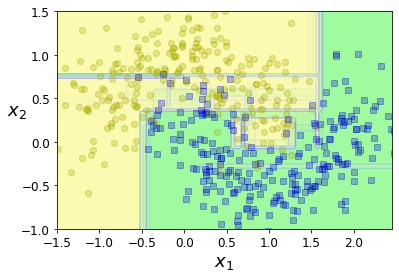

In [29]:
plt.figure(figsize=(6, 4))

# bootstrap방식의 sampling을 사용해서 수동으로 결정트리모델 결과 출력(결정경계)
for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement]) # 훈련세트 일부 선택
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

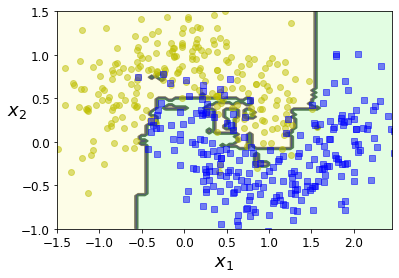

In [30]:
rf = RandomForestClassifier(n_estimators=15, random_state=42)
rf.fit(X_train, y_train)
plot_decision_boundary(rf, X, y, axes=[-1.5, 2.45, -1, 1.5])
plt.show()

#### Extra-Trees (Extremely Randomized Trees)

  - Extra trees방식이 다른점:

RandomForest에서 tree를 만들때 각 노드는 무작위로 특성의 서브셋을 만들어 branching out이 진행된다. 

tree를 더욱! 무작위하게 만들기위해 최적의 임곗값을 찾는대신 (일반적인 tree생성 방식), 후보 특성을 사용해서 무작위로 분할한 다음, 그중에서 최상의 분할을 선택한다.

이 방식도 편향을 늘리지만, 분산을 줄인다.(단, 성능이 더 좋은지는 교차검증으로 비교해봐야 암)

그리고 

일반적인 RandomForest방식보다 더 빠르다 b/c 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 tree 알고리즘에서 시간이 가장 많이 소요되는 작업중 하나이기때문에.


sci-kit learn의 ExtraTreesClassifier를 사용. 
(회귀는 ExtraTreesRegressor)


### 특성 중요도

scikit learn은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함. (randomforest에 있는 모든 tree에 걸쳐서)

In [31]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

# 각 특성의 중요로를 확인할 수 있음

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [32]:
rnd_clf.feature_importances_ # 이값들을 모두 더하면 1.0이 됨.

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [33]:
# MNIST data기반으로 이미지의 각 특성(픽셀) 중요도를 시각화해서 보여주는 예시 

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, #colormap spectrum: black(lowest)-red-yellow(highest)
               interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


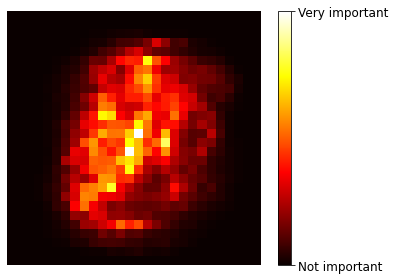

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# 특성 reshape해서 이미지로 다시 복원해서 시각화
# 각 픽셀의 중요도 확인가능 (사진의 경계쪽으로 갈수록 중요도)

## Boosting 알고리즘

boosting = hypothesis boosting

약한 학습기를 여러개 연결해서 강한 학습기를 만드는 ensemble 방법.

어떻게?
앞의 모델을 보완해 나가면서 예측기를 학습시킨다.

두가지 방식있음: 
   - AdaBoost
   - GradientBoost

#### 에이다 부스트 (Adaboost=Adaptive Boosting)

이전 예측기를 보완하며 새로운 예측기를 만들기위해 이전에 과소적합했던 훈련 샘플의 가중치를 더 높이는 방식.

즉, 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰진다.


In [ ]:
# AdaBoostClassifier는 기본적으로 decision tree classifier를 사용 (default : max_depth=1)
# AdaBoostRegressor는 기본적으로 DecisionTreeRegressor(max_depth=3) 사용

# SAMME: adaboost의 다중 클래스 버젼
# SAMME.R ('.R'은 real 실수값을 사용한다는 것): 각 tree가 예측한 확률값을 사용해서 좀 더 정확한 예측값을 도출
# SAMME: binary classification일때에 adaboost와 동일하다.

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, #첫번째 분류기의 결과를 기반으로 
    # 다음분류기의 오차를 보정해나아간다. 순차적으로 향상된 모델을 만들어감. 속도 느리지만, 성능 좋음.
    algorithm="SAMME.R", learning_rate=0.5, random_state=42) 
    # learning_rate: 추가되는 모델의 가중치를 조절 (0.5로 낮추는, 1.0로는 모두 동일한 가중치를 갖게됨)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

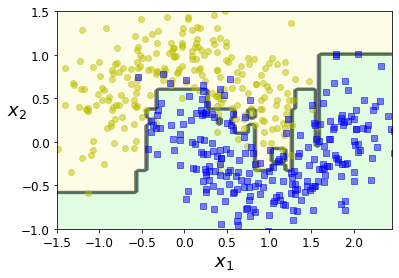

In [ ]:
plot_decision_boundary(ada_clf, X, y)

AdaBoost 분류기 만드는 방식:
1. 기반이 되는 첫번째 분류기 생성 (decisiontreeclassifier)해서 훈련세트에 훈련시키고 예측을 만든다.
2. 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
3. 두번째 분류기는 업데이트된 가중치를 사용해 훈련세크에서 훈련하고 다시 예측을 만든다.
4. 가중치를 업데이트하고 계속 반복.

그림 저장: boosting_plot


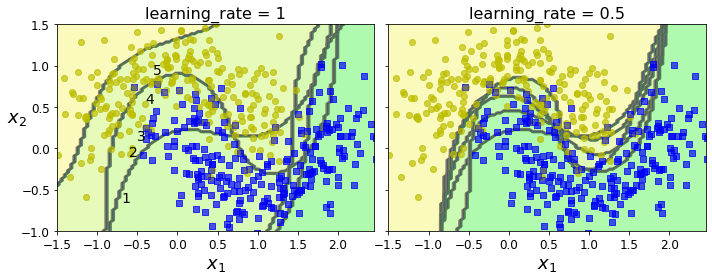

In [ ]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()
# 오른쪽은 학습률을 반으로 줄여서
# 잘못 분류된 샘플의 가중치가 반복마다 절반정도만 높아진다.

경사하강법과 비슷함.

경사하강법: cost function/loss function을 최소화 하기위해 모델의 파라미터를 조정해간다

adaboost:모델이 더 좋아지도록 ensemble에 예측기를 추가한다.

In [ ]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

In [ ]:
ada_clf.estimator_weights_ #ensemble의 tree들이 모두 동일한 가중치를 갖고있다는것 확인

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=42) 
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [ ]:
ada_clf.estimator_weights_ # SAMME 알고리즘 사용시, 가중치 각각 다름. 뒤쪽으로 갈수록 가중치 낮아짐

array([0.75367002, 0.54049801, 0.4224443 , 0.48647654, 0.31654854,
       0.379218  , 0.30032211, 0.31846391, 0.27158952, 0.17926049,
       0.31058992, 0.19282219, 0.29419055, 0.22303041, 0.12939442,
       0.26037109, 0.15927339, 0.25946793, 0.22941444, 0.1422021 ,
       0.22361957, 0.1549239 , 0.11170221, 0.19674255, 0.11689374,
       0.09087907, 0.09939409, 0.0699826 , 0.08082521, 0.09634825,
       0.22996886, 0.1964156 , 0.11396743, 0.20020455, 0.13475059,
       0.0981953 , 0.16731037, 0.10013918, 0.07909107, 0.19407372,
       0.09877874, 0.22921439, 0.10128315, 0.05559778, 0.07570118,
       0.14706034, 0.12596329, 0.05130632, 0.14715971, 0.08764181,
       0.07043982, 0.17506428, 0.08886183, 0.04443092, 0.13022963,
       0.10088737, 0.19500586, 0.08300459, 0.16257046, 0.06498438,
       0.05739202, 0.07403357, 0.04395452, 0.15326153, 0.08635956,
       0.06528596, 0.12361461, 0.07085821, 0.05691824, 0.06132247,
       0.04090863, 0.04972253, 0.04364593, 0.10235768, 0.08758

### 그래디언트 부스팅 (Gradient Boosting)

AdaBoosting(잘못예측하는 모델를 기반으로 후속 모델을 점진적으로 개선해가며 ensemble 모델의 향상된 성능을 얻는)과는 다르게, 

GradientBoosting은 앞에 만들어진 모델의 오차값을 보정해가면서 향상된 ensemble 모델을 만들어간다.

In [ ]:
# sample dataset 생성
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2) #훈련 데이터 셋의 target: y --> y2 ==> 오차값이 target값이 된다.

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3) #훈련 데이터 셋의 target: y2 --> y3 ==> 다음 오차값이 target값이 된다.

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

array([0.75026781])

GradientBoosting은 위와 같은 방식으로 첫번째 트리의 오차값을 두번째 트리가 보정하고, 두번째의 오차값을 세번때가 보정하고... 이어간다. 

그리고 예측값을 모두 더한 값을 final 예측값으로 출력한다.

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

그림 저장: gradient_boosting_plot


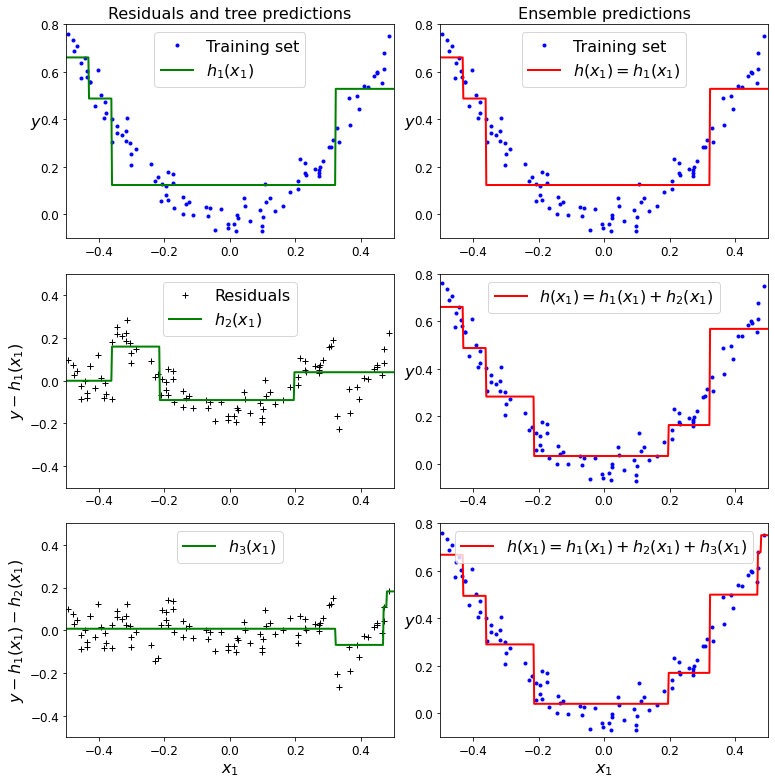

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [ ]:
# GradientBoostingRegressor은 고정적으로 DecisionTreeRegressor를 사용
# target - pred
# GradientBoostingClassifier(loss='deviance') <-- logistic손실함수와 동일

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

그림 저장: gbrt_learning_rate_plot


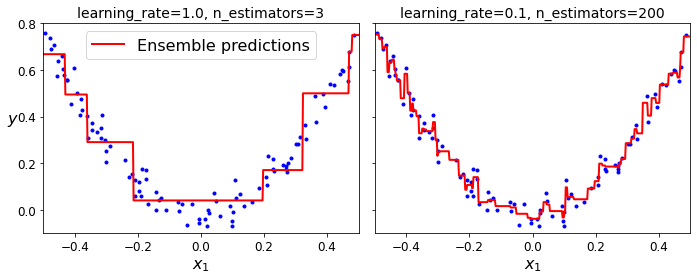

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

# 오른쪽 (n_estimator=200)은 과대적합으로 보인다.

#### 조기종료를 사용한 GradientBoosting

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)] #target과 predict값의 차이 구한다
bst_n_estimators = np.argmin(errors) + 1 # 가장 작은 에러값 선택

# n_estimators=bst_n_estimators 를 사용해서 조기종료 방식으로 실행가능하다.
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
min_error = np.min(errors)
min_error # 최소 에러값

0.002712853325235463

그림 저장: early_stopping_gbrt_plot


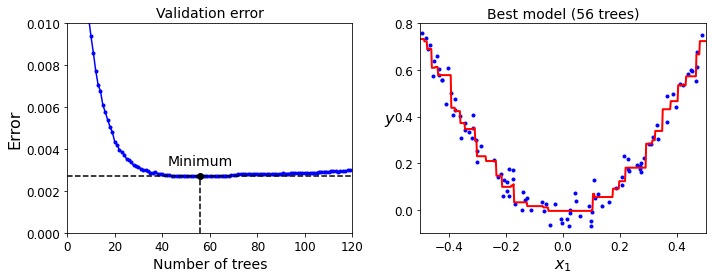

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

# 아까 n_estimator=200을 사용했을때보다 더 적절한 모델

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators # n_estimators 값을 계속 바꾸어준다
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error: # 이전에 계산한 최소 에러보다 작은지 확인
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping <--5번 에러가 더 증가하지 않으면 조기종료

In [ ]:
print(gbrt.n_estimators) # 이 ensemble의 최적의 tree 개수

61


In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


#### XGBoost 사용하기

XGBoost는 (sklearn이 아닌 XGBoost library에 따로 있음. Colab에는 기본적으로 깔려있음) history기반의 알고리즘

속도도 빠름, 일반화 성능 좋음

In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [ ]:
if xgboost is not None: 
    xgb_reg = xgboost.XGBRegressor(random_state=42, n_estimator=100, max_depth=3)
    # 파라미터 기본 값: n_estimator=100, max_depth=3
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)           

[14:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [ ]:
if xgboost is not None:  
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    # rounds = tree를 추가하는 반복횟수
    # boosting 횟수가 2번 반복되어도 검증세트 점수가 좋아지지 않으면 조기 종료하도록 설정됨.
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  
    print("Validation MSE:", val_error)    # 검증세트의 점수 출력해서 확인        

[14:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

In [ ]:
# 속도 측정 (커맨드: %timeit)
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 5: 24.2 ms per loop


==> XGBoost가 GradientBoost보다 2배 가까이 빠르다.

In [ ]:
# lightgbm -Microsoft에서 최근에 만든, colab에 기본적으로 깔려있음.

from lightgbm import LGBMRegressor
lgb_reg = LGBMRegressor(random_state=42)
lgb_reg.fit(X_train, y_train)

y_pred = lgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
val_error

0.01777549654697777

In [ ]:
# lightgbm이 최근에 나온 모델로서 최신 아이디어가 더 많이 반영되어있음.
# 빠르고, 성능이 좋음

%timeit LGBMRegressor().fit(X_train, y_train)

100 loops, best of 5: 6.1 ms per loop


In [ ]:
# 0.21v - 실험적인 
# 꼭 enable_hist_gradient_boosting import해야함.

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
hgb_reg = HistGradientBoostingRegressor()
hgb_reg.fit(X_train, y_train)

y_pred = hgb_reg.predict(X_val)

In [ ]:
# 상대적으로 느림

%timeit HistGradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 5: 29.4 ms per loop


### 스태킹(Stacking= Stacked generalization)

ensemble에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하지 않고, 취합하는 모델을 훈련시키기위해 사용한다.

ensemble을 구성하는 각각의 예측기가 다른값을 예측하고, **blender (블랜더) 또는 meta learner (메타학습기)**가 이 예측값들을 입력받아서 최종 예측값을 만들어낸다.



**stacking의 예시:**

  - 홀드아웃 세트 사용 방법:
1. 훈련세트를 2개의 서브셋으로 나눈다.
2. 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기위해 사용됨. (하나의 레이어에는 3개의 예측기가 있음)
3. 첫번째 레이어의 예측기를 사용해서 두번째(홀드 아웃) 세트에 대한 예측을 만든다.
4. 예측기들이 훈련하는 동안 이 홀드아웃 세트는 이전에 보지못했던 것이기때문에 새로운 예측값이 만들어진다. 홀드아웃 샘플들에 대해 세개의 예측 값이 만들어짐.
5. 타깃 값을 그대로 쓰고, 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다 (3차원)
6. 블렌더를 이 새로운 훈련 세트로 훈련된다. (첫번째 레이어의 예측 값을 가지고 target값을 예측하도록 학습)



  - 블렌더를 여러개 훈련시키는 방법:

1. 훈련세트를 3개의 subset으로 나눈다.
2. 첫번째 세트는 첫번째 레이어를 훈련 시키는데에 사용
3. 두번째 세트는 (첫번째 레이어의 예측기로) 두번째 레이어를 훈련시키기 위한 훈련세트를 만드는데에 활용됨.
4. 세번째 세트는 (두번째 레이어의 예측기로) 세번째 레이어를 훈련시키기위한 훈련 세트를 만드는데에 사용됨.
5. 그리고 작업이 끝나면, 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있다.

sci-kit learn은 stacking을 지원하지 않는다. 그대신 brew와 같은 open source를 사용할 수 있다. 

http://github.com/viisar/brew